In [1]:
from model import *
#from dilateModel import *
#from model_edge import *
from data import *
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
import cv2

import argparse
import imutils

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt
import skimage.feature
import skimage.viewer
import sys

from skimage import transform

%matplotlib notebook

Using TensorFlow backend.
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packag

## Train Model

### Train with Data Generator; Augment Data with Hyper-Parameters

In [2]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(8,'/data/spacenet/bldg/AllTrain','PAN-PNG','GT-PNG',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane_AllTrain_8.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=50,epochs=10,callbacks=[model_checkpoint])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/dspuser/unet/model.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


KeyboardInterrupt: 

## Make Prediction

### Load Weights to Prepare Model for Use

In [2]:
model = unet()
model.load_weights("Humphries_Bragg_Weights.hdf5")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/dspuser/unet/model.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


### Define Helper Functions to Reshape Image Before Prediction

In [3]:
def predImgGen(imgPath, target_size=(256,256)):
    img = io.imread(imgPath,as_gray = True)
    img = img / 255
    img = trans.resize(img,target_size)
    img = np.reshape(img,img.shape+(1,))
    img = np.reshape(img,(1,)+img.shape)
    return img

### Prediction Loop: Walk through Test Folder, reshape image, make prediction, threshold image, overlay prediction on original. 

#### maskImg: image of just predicted masks

#### maskImgRe: larger image of predicted masks

#### PANImg: original image

#### comp: combined image with predictions overlayed over original image

In [4]:
maskImg_List = []
test_dir = '/data/spacenet/bldg/AllTest/PAN-PNG'
for i,j,k in os.walk(test_dir):
    for file in k:
        if (os.path.splitext(file)[1] == '.png'):
            PANImgPath = os.path.join(test_dir, file)
            testImg = predImgGen(PANImgPath)
            pred = model.predict(testImg)
        
            predRe = pred.reshape(256,256)
            maskArrThresh = np.zeros((predRe.shape[0], predRe.shape[1], 4)) 
            maskArrThresh[:,:, 0] = 50
            maskArrThresh[:,:, 1] = 255
            maskArrThresh[:,:, 2] = 0
            for row in range(0, predRe.shape[0]):
                for col in range(0, predRe.shape[1]):
                    maskArrThresh[row, col, 3] = 255 - int(predRe[row, col] * 255)
            maskArrThresh = maskArrThresh.astype("uint8")
            maskImg = Image.fromarray(maskArrThresh, 'RGBA')
            
            maskImg.save(file)
        
            PANImg = Image.open(PANImgPath)
            PANImgT = PANImg.convert('RGBA')
        
            PANDim = (PANImgT.width, PANImgT.height)
            maskImgRe = maskImg.resize(PANDim)
            #maskImg_List += [maskImgRe]
        
            comp = Image.alpha_composite(PANImgT, maskImgRe)
            #comp.save(file)

## Find Center Point

### Resize prediction (maskImgRe) to prepare for inversion 

In [28]:
np_image1 = Image.open('PAN_AOI_2_Vegas_img1016.png')

np_image1 = np.array(np_image1).astype('float32')/255
np_image1 = transform.resize(np_image1, (256, 256, 1))
np_image1 = np.expand_dims(np_image1, axis=0)


### Invert image; this is necessary in order to use findContours function (see below)

In [29]:
invert1 = cv2.bitwise_not(np_image1)

### Save image to 'data' folder

In [30]:
saveResult("",invert1)

#cv2.imwrite('unet/predict.png',invert1)



Lossy conversion from float32 to uint8. Range [-12.256722450256348, -7.9792351722717285]. Convert image to uint8 prior to saving to suppress this warning.


### Find Contours

#### Prepare Image for findContours: Load the image, convert it to grayscale, blur it slightly, and threshold it

In [31]:
# load the image, convert it to grayscale, blur it slightly,
# and threshold it
#image = cv2.imread("PAN_AOI_2_Vegas_img1016.png")
image = cv2.imread('0_predict.png')
#print('shape={}'.format(image.shape))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)[1]

#### Display pre-processed image

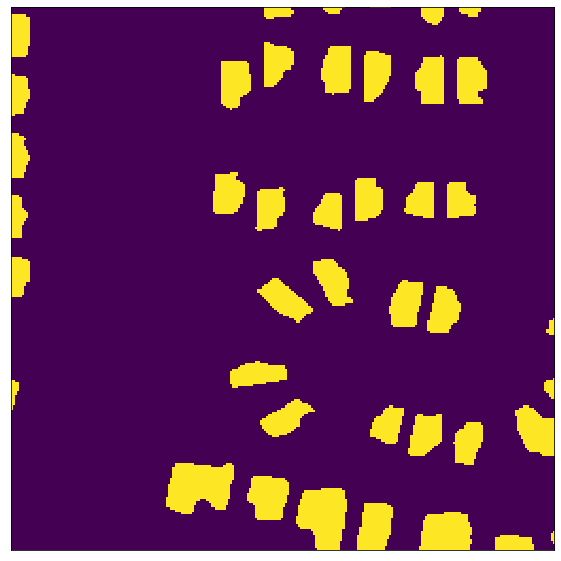

In [32]:
plt.figure(figsize = (10,10))
plt.imshow(thresh)
plt.xticks([]), plt.yticks([])
plt.show()

#### Read and show original image

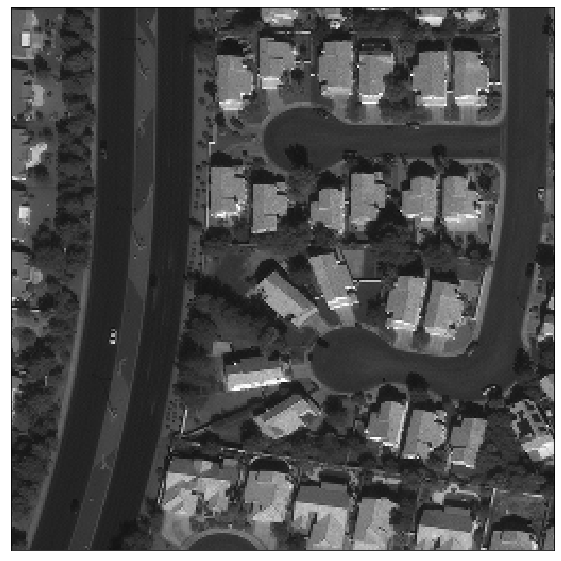

In [34]:
#real_image = cv2.imread('/data/spacenet/bldg/AllTest/PAN-PNG/PAN_AOI_5_Khartoum_img1001.png')
real_image = cv2.imread('/data/spacenet/bldg/AllTest/PAN-PNG/PAN_AOI_2_Vegas_img1016.png')
real_image = cv2.resize(real_image, (256,256))

plt.figure(figsize = (10,10))
plt.imshow(real_image)
plt.xticks([]), plt.yticks([])
plt.show()

#### Find Contours

In [35]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#cnts

#### Draw Contours on Real Image

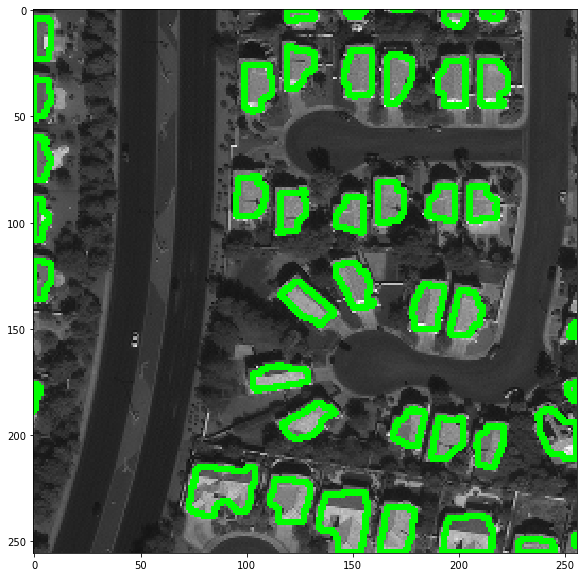

In [36]:
img_cnt = cv2.drawContours(real_image, cnts, -1, (0, 255, 0), 2)

plt.figure(figsize = (10,10))
plt.imshow(img_cnt)

#### Find and Label Center Points for each Contour

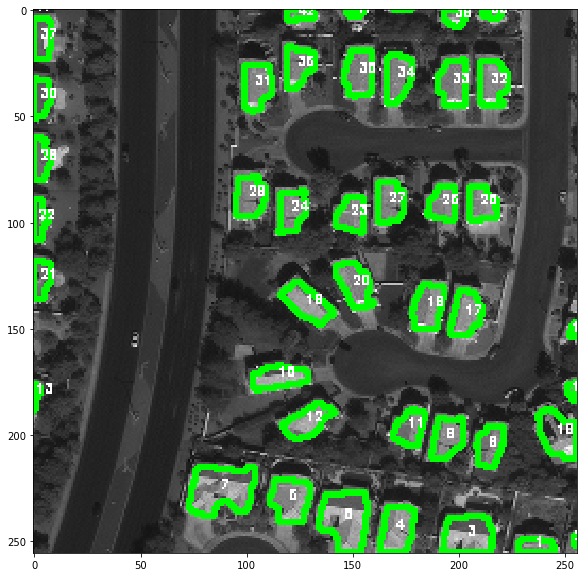

In [38]:
# loop over the contours
plt.figure(figsize = (10,10))
i=1
for c in cnts:
    # compute the center of the contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
    # set values as what you need in the situation
        cX, cY = 0, 0
#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])
    # draw the contour and center of the shape on the image
    #cv2.drawContours(real_image, [c], -1, (0, 255, 0), 2)
    #cv2.circle(real_image, (cX, cY), 2, (255, 255, 255), -1)
    cv2.putText(real_image, str(i), (cX, cY),cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 255, 255), 0)
    # show the image
    plt.imshow(real_image)
    cv2.waitKey(0)
    i+=1
# plt.imshow(image)
# plt.xticks([]), plt.yticks([])
# plt.show()
#saveResult("data/membrane/test2",image)